In [28]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from numpy.random import rand,randint
import scipy.ndimage
from scipy.sparse import csc_matrix, csr_matrix
import json
import matplotlib.pyplot as plt
import queue
import functools
import pandas

In [327]:
RANDOM_SEED = 42
cluster_number = 256
weights = rand(300,784)

### Clustering

In [3]:
def reshape_weights_for_kmeans(weights):
    return np.hstack(weights).reshape(-1,1)

def build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(reshape_weights_for_kmeans(weights))
    return kmeans.cluster_centers_

In [4]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    return (np.abs(centers - value)).argmin()

def nearest_centroid(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return centers[idx]

### Matrix

In [5]:
def redefine_weights(weights,centers):
    arr_ret = np.empty_like(weights).astype(np.int16)
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            arr_ret[i,j] = nearest_centroid_index(centers,weights[i,j])
    return arr_ret

In [6]:
def idx_matrix_to_matrix(idx_matrix,centers,shape):
    return centers[idx_matrix.reshape(-1,1)].reshape(shape)

In [7]:
def centroid_gradient_matrix(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix,index=range(cluster))

### Dictionary

In [8]:
# map (i,j) -> k
def dict_index_to_cluster(weights,centers):
        dict_ret = {}
        for i, row in enumerate(weights):
            for j, col in enumerate(row):
                dict_ret[(i,j)] = nearest_centroid_index(centers,weights[i,j])
        return dict_ret

# map k -> (i,j)
def dict_cluster_to_index(dict_idx):
    dict_ret = {}
    for k,v in dict_idx.items():
        if v in dict_ret:
            dict_ret[v] += [k]
        else:
            dict_ret[v] = [k]
    return dict_ret

In [9]:
def index_dict_to_matrix(dict_index,dict_values,shape):
    coord_array = np.asarray(list(dict_index.values()))
    return dict_values[coord_array].reshape(shape)

In [10]:
def centroid_gradient_dict(K_Index,W_Matrix):
    tmpindex = dict((key, ([x for x, _ in value], [y for _, y in value])) for key, value in K_Index.items())
    return [W_Matrix[value[0],value[1]].sum() for value in tmpindex.values()]

### Variables

In [11]:
centers = build_clusters(cluster_number,weights)
dict_index = dict_index_to_cluster(weights,centers)
dict_cluster = dict_cluster_to_index(dict_index)
matrix_index = redefine_weights(weights,centers)

### Testing

In [12]:
%timeit idx_matrix_to_matrix(matrix_index,centers,(300,784))
%timeit index_dict_to_matrix(dict_index,centers,(300,784))

706 µs ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
18.5 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit centroid_gradient_matrix(matrix_index,weights,cluster_number)
%timeit centroid_gradient_dict(dict_cluster,weights)

1.61 ms ± 79.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
76.2 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Transform

In [14]:
def dict_to_index_matrix_slow(dict_cluster):
    arr_ret = np.zeros((300,785))
    for k,v in dict_cluster.items():
        for i in v:
            arr_ret[i] = k
    return arr_ret

def dict_to_index_matrix(dict_index,shape):
    return np.asarray(list(dict_index.values())).reshape(shape).astype(np.int16)

In [15]:
%timeit dict_to_index_matrix_slow(dict_cluster)
%timeit dict_to_index_matrix(dict_index,(300,784))

50.3 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
17.1 ms ± 488 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# HELPER FUNCTION

#### Cluster mean

In [16]:
def mean_distance(weights,centroids):
    tot = 0.
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            weight = weights[i,j]
            centroid = nearest_centroid(centroids,weight)[0]
            tot += np.sqrt((weight - centroid)**2)
    return tot / ((i+1)*(j+1))

In [17]:
def find_clusters_number(values,n_from,n_to,n_jump):
    result = {}
    for i in range(n_from,n_to+1,n_jump):
        kmeans = MiniBatchKMeans(n_clusters=i,random_state=RANDOM_SEED)
        kmeans.fit(reshape_weights_for_kmeans(values))
        mean = mean_distance(values,kmeans.cluster_centers_)
        result[i] = mean
        print("Mean for %s clusters %f " % (str(i).zfill(3),mean))
    return result
        
means_cluster_1_10 = find_clusters_number(weights,1,101,10)

Mean for 001 clusters 0.249903 
Mean for 011 clusters 0.023029 
Mean for 021 clusters 0.011968 
Mean for 031 clusters 0.008139 
Mean for 041 clusters 0.006185 
Mean for 051 clusters 0.004948 
Mean for 061 clusters 0.004147 
Mean for 071 clusters 0.003554 
Mean for 081 clusters 0.003155 
Mean for 091 clusters 0.002889 
Mean for 101 clusters 0.002623 


## Huffman Coding

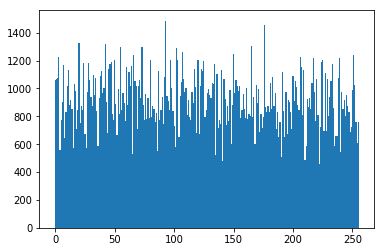

In [18]:
cluster_sparsity = [(len(dict_cluster[x]),x) for x in dict_cluster]
cluster_sparsity = sorted(cluster_sparsity, key=lambda x: x[0] )
plt.bar([x[1] for x in cluster_sparsity], [x[0] for x in cluster_sparsity], width=1)
plt.show()

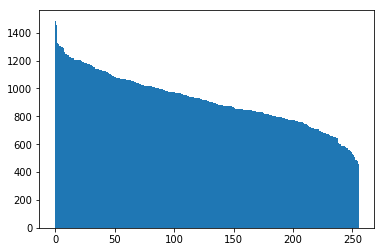

In [19]:
plt.bar(range(len(cluster_sparsity)), [x[0] for x in sorted(cluster_sparsity, key=lambda x: x[0], reverse=True)], width=1)
plt.show()

In [20]:
@functools.total_ordering
class HuffmanNode(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right
    def children(self):
        return((self.left, self.right))
    def __lt__(self, other):
        return True

def create_tree(frequencies):
    p = queue.PriorityQueue()
    for value in frequencies:
        p.put(value)
    while p.qsize() > 1:
        l, r = p.get(), p.get()
        node = HuffmanNode(l, r)
        p.put((l[0]+r[0], node))    
    return p.get()

# Dictionary (n : "01010")
def coding_tree(node, prefix="", code={}):
    if isinstance(node[1].left[1], HuffmanNode):
        coding_tree(node[1].left,prefix+"0", code)
    else:
        code[node[1].left[1]]=prefix+"0"
    if isinstance(node[1].right[1],HuffmanNode):
        coding_tree(node[1].right,prefix+"1", code)
    else:
        code[node[1].right[1]]=prefix+"1"
    return(code)

def decode(rev_huff,code):
    for k, v in rev_huff.items():
        if v == code:
            return k
        
def encode(rev_huff,code):
    return rev_huff[code]

# Dictionary ("01010" : n)
def reverse_code(huff):
    huff_code_rev = {}    
    for k,v in huff.items():
        huff_code_rev[v] = k
    return huff_code_rev

def rev_encode(rev_huff,code):
    return decode(rev_huff,code)
        
def rev_decode(rev_huff,code):
    return encode(rev_huff,code)

In [21]:
cluster_sparsity = [(len(v),k) for k,v in dict_cluster.items()]
ht_cluster = create_tree(cluster_sparsity)
hc_cluster = coding_tree(ht_cluster,code={})
hc_rev = reverse_code(hc_cluster)

list(hc_cluster.items())[0:10]

[(107, '0000000'),
 (8, '00000010'),
 (104, '00000011'),
 (102, '0000010'),
 (55, '0000011'),
 (73, '0000100'),
 (188, '00001010'),
 (193, '00001011'),
 (165, '0000110'),
 (236, '00001110')]

In [22]:
def nearest_centroid_index_huffman(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return encode(hc_cluster,idx)

def redefine_weights_huffman(weights,centers):
    arr_ret = np.empty_like(weights).astype(str)
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            arr_ret[i,j] = nearest_centroid_index_huffman(centers,weights[i,j])
    return arr_ret

def dict_index_to_cluster_huffman(weights,centers):
        dict_ret = {}
        for i, row in enumerate(weights):
            for j, col in enumerate(row):
                dict_ret[(i,j)] = nearest_centroid_index_huffman(centers,weights[i,j])
        return dict_ret
    
def index_dict_to_matrix_huffman(dict_index,dict_values,huff_code,shape):
    coord_array = np.asarray([rev_decode(huff_code,x) for x in huff_dict_index.values()])
    return dict_values[coord_array].reshape(shape)

def centroid_gradient_matrix_huffman(idx_huff_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_huff_matrix,[x for x in cluster.values()])

huff_index_matrix = redefine_weights_huffman(weights,centers)
huff_dict_index = dict_index_to_cluster_huffman(weights,centers)

In [23]:
%timeit index_dict_to_matrix(dict_index,centers,(300,784))
%timeit index_dict_to_matrix_huffman(huff_dict_index,centers,hc_rev,(300,784))

16.8 ms ± 25.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
54.9 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%timeit centroid_gradient_matrix(matrix_index,weights,cluster_number)
%timeit centroid_gradient_matrix_huffman(huff_index_matrix,weights,hc_cluster)

1.23 ms ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
119 ms ± 8.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
# Per Huffman non è possibile fare nulla (implementazione)
# Alla fine di tutto calcolare un'ipotetica compressione (funzione che restituisce il tasso)
# sommatoria: grandezza di ogni cluster (# elementi) * lunghezza stringa in char (8b a char)
# in confronto con # elementi * 8b

## PRUNING (with kmeans support)

In [324]:
def pruning_matrix(mat,percentage,method='out'):
    threshold = (100-percentage)
    
    if method == 'inout':
        threshold /= 4
        perc_up,perc_down,perc_mid_up,perc_mid_down = 100 - threshold, threshold, 50 + threshold, 50 - threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        percentile_mid_up = np.percentile(mat,perc_mid_up)
        percentile_mid_down = np.percentile(mat,perc_mid_down)
    else:
        threshold /= 2
        if method == 'in': perc_up, perc_down = 50 + threshold, 50 - threshold
        elif method == 'out': perc_up, perc_down = 100 - threshold, threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        
    w_pruned = np.copy(mat)
    for i,row in enumerate(mat):
        for j,_ in enumerate(row):
            if method == 'in':
                if mat[i,j] > percentile_down and mat[i,j] < percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'out':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'inout':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up or (mat[i,j] > percentile_mid_down and mat[i,j] < percentile_mid_up):
                    w_pruned[i,j] = 0
    return w_pruned

In [330]:
w_csc = csc_matrix(pruning_matrix(weights,70,method='in'))

In [331]:
def P_nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    return (np.abs(centers - value)).argmin()

In [332]:
def P_build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(weights.data.reshape(-1,1))
    return kmeans.cluster_centers_

P_centers = P_build_clusters(256,w_csc)

In [333]:
def P_redefine_weights(weights,centers):
    new_data_idx = [nearest_centroid_index(centers,w) for w in weights.data]
    return csc_matrix((new_data_idx,weights.indices,weights.indptr))

idx_csc = P_redefine_weights(w_csc,P_centers)

In [334]:
def P_idx_matrix_to_matrix(idx_matrix,centers):
    return csc_matrix((centers[idx_matrix.data].reshape(-1,),idx_matrix.indices,idx_matrix.indptr))

%timeit P_idx_matrix_to_matrix(idx_csc,P_centers)

484 µs ± 444 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [349]:
def P_centroid_gradient_matrix(idx_matrix,gradient,mask,cluster):
    gradient[mask] = 0
    return scipy.ndimage.sum(csc_matrix(gradient).data,idx_matrix.data,index=range(cluster))

mask = w_csr.A == 0
gradient = weights.copy()
cgm = P_centroid_gradient_matrix(idx_csr,gradient,mask,256)
np.array(range(256)) - cgm

array([-361.60647057, -250.8533982 , -380.05750312, -267.13811395,
       -357.6008214 , -294.97999345, -275.33679171, -470.2282777 ,
       -276.93914027,  -89.02331442, -466.66607795, -181.23908097,
       -499.50111643, -466.813615  , -273.26839307, -497.89209079,
       -149.35473404, -492.64760517, -314.05500243, -209.78921101,
       -303.55856785, -268.74296712, -219.46881714, -384.0414072 ,
       -319.47289521, -384.6918591 , -576.00404057, -293.32281695,
       -264.2356986 , -371.525988  , -284.12285115, -385.99846493,
       -383.00794206, -298.83686892, -429.4595744 , -125.82173782,
       -672.8492079 , -155.68352838, -354.51992333, -297.80936116,
       -430.59782556, -157.4134859 ,  -85.44524768, -302.65746651,
       -416.09297831, -107.42098971, -318.00080268, -280.71653785,
         48.        , -375.37810927, -462.5541124 , -322.30304512,
       -384.51332713, -545.00242551, -236.86421364, -232.68249572,
       -199.85525558, -387.71499997, -413.83129171, -198.15368

In [340]:
idx_csc

<300x784 sparse matrix of type '<class 'numpy.int64'>'
	with 164640 stored elements in Compressed Sparse Column format>

## CSC Matrix

In [35]:
# multiplication
# csr * dense

In [177]:
cc = csc_matrix(pruned)
cr = csr_matrix(pruned)
a = np.array(range(21)).reshape(3,7)
b = np.array(range(20,41)).reshape(3,7)
acc = csc_matrix(a)
acr = csr_matrix(a)
acc.A

array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13],
       [14, 15, 16, 17, 18, 19, 20]], dtype=int64)

In [153]:
# in place
def sparse_sub_dense(sparse,dense,mask):
    sparse.A -= dense
    sparse.A[mask] = 0
    return csc_matrix((sparse.data,sparse.indices,sparse.indptr))

In [164]:
maskBig = cc.A == 0 
%timeit sparse_subtract_dense(cc,weights-1,maskBig)
%timeit sparse_subtract_dense(cr,weights-1,maskBig)

2.18 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.58 ms ± 92.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [144]:
def delete_last_row_csc(matrix):
    i = matrix.indptr[-1]
    indptr = matrix.indptr[:-1]
    data = matrix.data[:i]
    indices = matrix.indices[:i]
    return csc_matrix((data,indices,indptr))

In [145]:
%timeit delete_last_row(t)

164 µs ± 371 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [191]:
v = np.array([1,2,1,1,2,1,1])
np.inner(acc.A,v),acc*v.T,acc*v

(array([ 26,  89, 152], dtype=int64),
 array([ 26,  89, 152], dtype=int64),
 array([ 26,  89, 152], dtype=int64))